In [1]:
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
df=pd.read_csv('./dataset/dress/dress.csv')
print(df.head())

    _unit_id   category  category:confidence  \
0  851505458       ikat               0.3487   
1  851505459      plain               1.0000   
2  851505460  polka dot               0.6709   
3  851505461      plain               1.0000   
4  851505462   geometry               0.7035   

                                           image_url  
0  http://s3-eu-west-1.amazonaws.com/we-attribute...  
1  http://s3-eu-west-1.amazonaws.com/we-attribute...  
2  http://s3-eu-west-1.amazonaws.com/we-attribute...  
3  http://s3-eu-west-1.amazonaws.com/we-attribute...  
4  http://s3-eu-west-1.amazonaws.com/we-attribute...  


In [3]:
##basic function to load url and get an image
def url_image(url):
    response=urllib.request.urlopen(url)
    image=np.asarray(bytearray(response.read()),dtype='uint8')
    image_bgr=cv2.imdecode(image,cv2.IMREAD_COLOR)
    image_rgb=cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)
    image_hsv=cv2.cvtColor(image_bgr,cv2.COLOR_BGR2HSV)
    print(type(image_rgb))
    plt.imshow(image_hsv)

<class 'numpy.ndarray'>


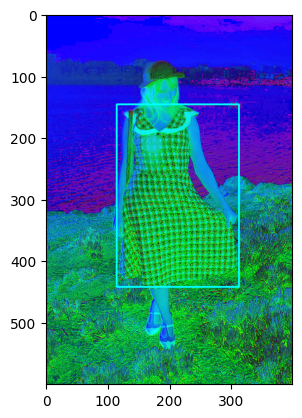

In [4]:
plt.figure()
url_image(df['image_url'].loc[2])

In [5]:
def image_preprocessing(image_url):
    #same as before
    response=urllib.request.urlopen(image_url)
    image=np.asarray(bytearray(response.read()),dtype='uint8')
    image_bgr=cv2.imdecode(image,cv2.IMREAD_COLOR)
    image_hsv=cv2.cvtColor(image_bgr,cv2.COLOR_BGR2HSV)
    image_gray=cv2.cvtColor(image_bgr,cv2.COLOR_BGR2GRAY)
    #create a mask using hsv image
    mask=cv2.inRange(image_hsv,(0,255,255),(0,255,255))
    #geting the coordinate of rectangle
#     y1=0
#     y2=0
    if len(np.where(mask!=0)[0])!=0:
        y1=min(np.where(mask!=0)[0])
        y2=max(np.where(mask!=0)[0])
    else:
        y1=0
        y2=len(mask)
    if len(np.where(mask!=0)[1])!=0:
        x1=min(np.where(mask!=0)[1])
        x2=max(np.where(mask!=0)[1])
    else:
        x1=0
        x2=len(mask[0])
    #crop the image
    image_cropped=image_gray[y1:y2,x1:x2]
    #resize all images to 100*100
    image_resized=cv2.resize(image_cropped,(100,100))
    image_array=image_resized.flatten()
    return image_array

In [ ]:
image_list=[]
for url in df['image_url']:
    image_list.append(image_preprocessing(url))
X=np.array(image_list)
X=X/255

In [6]:
X=np.load('./dataset/dress/X.npy')

In [7]:
print(X.shape)

(15189, 10000)


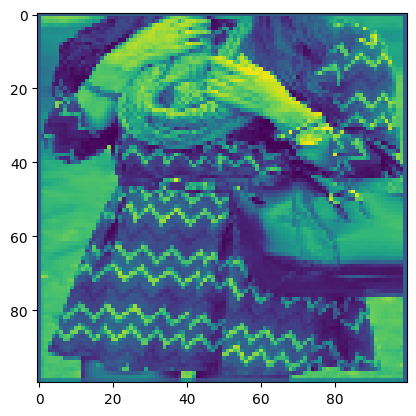

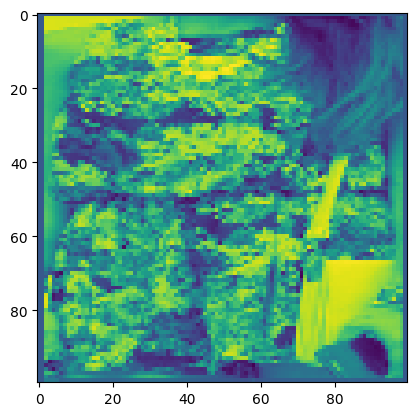

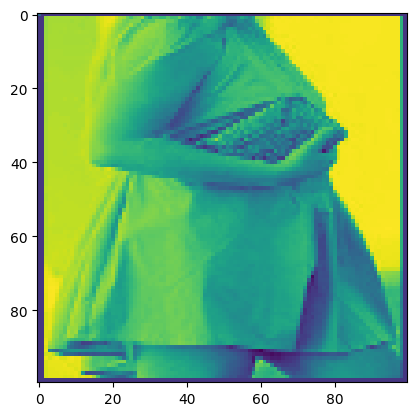

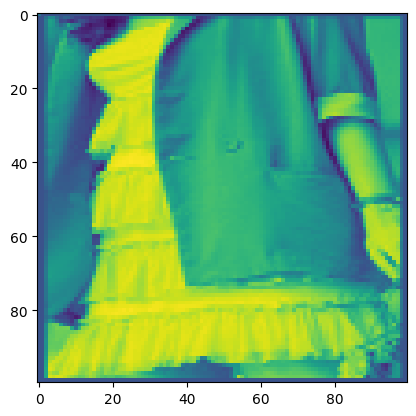

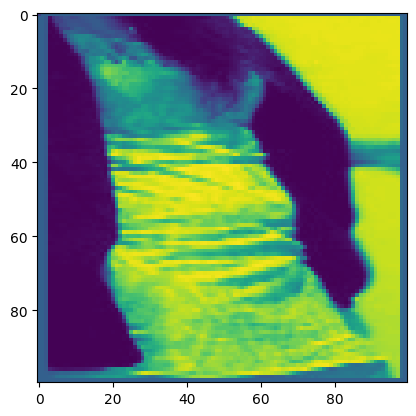

In [8]:
np.random.seed(18)
for i in np.random.randint(0,len(X),5):
    plt.figure()
    plt.imshow(X[i].reshape(100,100))

In [9]:
print('all categories:\n',df['category'].unique())

all categories:
 ['ikat' 'plain' 'polka dot' 'geometry' 'floral' 'squares' 'scales'
 'animal' 'OTHER' 'stripes' 'tribal' 'houndstooth' 'cartoon' 'chevron'
 'stars' 'letter_numb' 'skull']


In [10]:
n_classes=df['category'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 17


In [11]:
df=df.loc[(df['category']!='OTHER')].reset_index(drop=True)

preprocessing is completed

In [12]:
encoder=LabelEncoder()
Targets=encoder.fit_transform(df['category'])
print(Targets)
print(Targets.shape)

[ 6  8  9 ... 12 15  9]
(15189,)


In [13]:
Y=to_categorical(Targets,num_classes=n_classes)
Y.shape

(15189, 17)

In [14]:
#Segregation of a test set for testing on the trained model

X_test = X[14000:,]
Y_test = Y[14000:,]

#Seperation of a validation set from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:14000,], Y[:14000,], test_size=0.15, random_state=13)

In [15]:
img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(2100, 100, 100, 1)

In [16]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

learning_rate = 0.001

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 98, 98, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 batch_normalization_1 (Bat  (None, 96, 96, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                        

In [17]:
save_at="./model.hdf5"
save_best=ModelCheckpoint(save_at,monitor='val_accuracy',verbose=0,save_best_only=True,save_weights_only=False,mode='max')

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 1.8013 - accuracy: 0.6093

C:\Users\karth\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 132s 1s/step - loss: 1.8013 - accuracy: 0.6093 - val_loss: 1.9062 - val_accuracy: 0.5690
Epoch 2/10
119/119 [==============================] - 136s 1s/step - loss: 1.3294 - accuracy: 0.6666 - val_loss: 1.6174 - val_accuracy: 0.5795
Epoch 3/10
119/119 [==============================] - 207s 2s/step - loss: 1.2574 - accuracy: 0.6822 - val_loss: 1.3201 - val_accuracy: 0.6281
Epoch 4/10
119/119 [==============================] - 224s 2s/step - loss: 1.2029 - accuracy: 0.6928 - val_loss: 1.3065 - val_accuracy: 0.6624
Epoch 5/10
119/119 [==============================] - 220s 2s/step - loss: 1.1618 - accuracy: 0.6993 - val_loss: 1.6499 - val_accuracy: 0.5143
Epoch 6/10
119/119 [==============================] - 3782s 32s/step - loss: 1.1180 - accuracy: 0.7059 - val_loss: 1.3095 - val_accuracy: 0.6829
Epoch 7/10
119/119 [==============================] - 134s 1s/step - loss: 1.0884 - accuracy: 0.7154 - val_loss: 1.2821 - val_accuracy: 0.6986
Epoch 8/

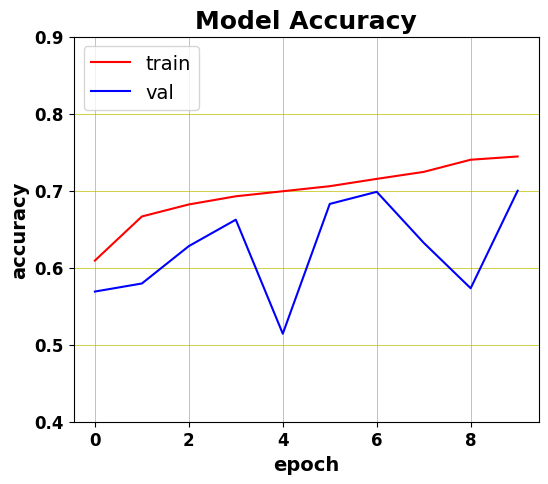

In [18]:
history=model.fit(X_train,Y_train,epochs=10,batch_size=100,callbacks=[save_best],verbose=1,validation_data=(X_val,Y_val))


plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy',weight='bold',fontsize=18)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.4, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [21]:
model=load_model('model.hdf5')
score=model.evaluate(X_test,Y_test,verbose=0)
print('Accuracy over test data: ',round(score[1]*100,2),'%')

Accuracy over test data:  119.91 %


38/38 [==============================] - 2s 57ms/step


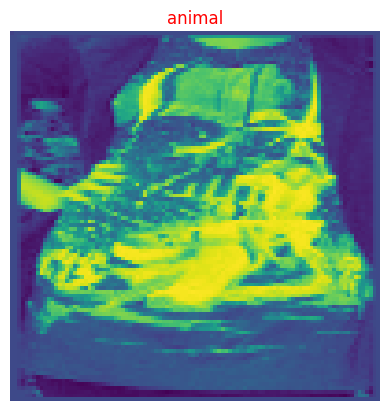

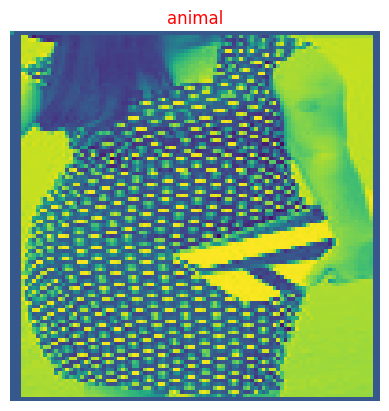

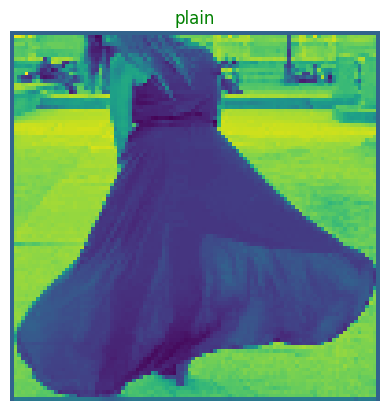

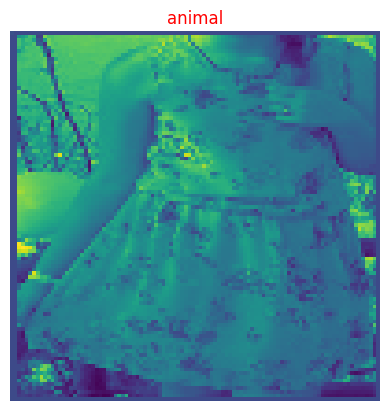

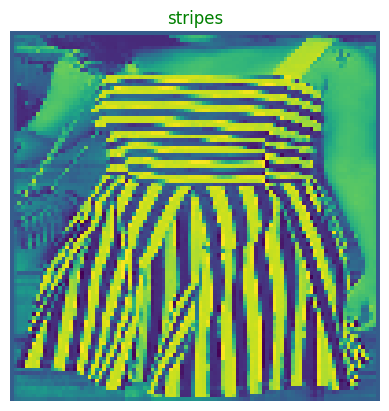

In [63]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(87)
for rand_num in np.random.randint(0, len(Y_test), 5):
  plt.figure()
  plt.imshow(X_test[rand_num].reshape(100, 100)), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

In [64]:
query_image=plt.imread('./dataset/dress/query_image.jpg')

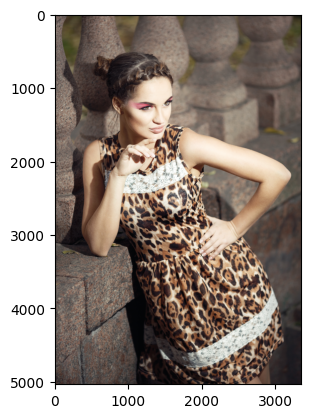

In [66]:
plt.imshow(query_image)

1/1 [==============================] - 0s 219ms/step


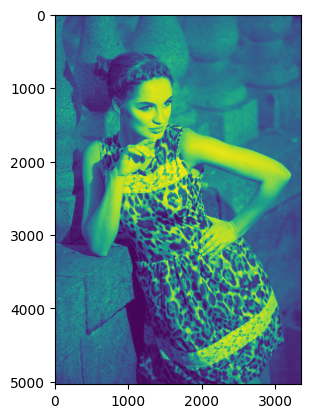

In [75]:
# query_image_bgr = cv2.imdecode(query_image, cv2.IMREAD_COLOR)
query_image_gray = cv2.cvtColor(query_image, cv2.COLOR_RGB2GRAY)
plt.imshow(query_image_gray)
image_100x100 = cv2.resize(query_image_gray, (100, 100))
X_query=image_100x100.reshape(1, 100, 100, 1)
Y_query_pred=np.round(model.predict(X_query))

In [82]:
print(Y_query_pred)
i=np.where(Y_query_pred==1)
print(i[1])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[2]


In [85]:
print('Type detected by model:', encoder.classes_[i[1][0]].upper())

Type detected by model: CHEVRON
